# Using Language Model Embeddings to find similar Agent of the City documents

Can we use an LSTM language model to find similar documents?

We think so. We're going to take apart a Fastai classifier model and put it back together again to generate a 1,200-dimensional embedding of the input document (instead of a binary classification). That 1,200 dimensional embedding is identical to the input to the linear portion of the classification model; we've just lopped off the bottom.

Once we have that embedding, we can compare them between documents to have a way to measure the similarity of documents, so we can do an unsupervised clustering of documents. 

Practically, if we imagine that we're investigative journalists with a pile of documents too big to read, we can find an interesting document manually, then ask the computer to find us more similar documents. 

# Step 0: Get the data

We've got a bunch of [emails](https://github.com/Quartz/aistudio-doc2vec-for-investigative-journalism/raw/master/2018.05.24_BerlinRosen_Responsive_Records.pdf) about various city business sent and received by NYC mayor Bill de Blasio. (NYC Politics nerd? These are the "Agent of the City" emails.)

Each page is a row in this CSV. At the very bottom of the notebook is a snippet for transforming the PDF to CSV.

In [1]:
csv_file = "nyc_docs.csv"

In [15]:
!wc nyc_docs.csv

 153083  805492 5530396 nyc_docs.csv


# Step 1: Training our Language Model

this is the same as normal Fastai. Nothin' special.

See below for code.

# Step 2: Getting Docuemnt Embeddings

We're breaking the model apart into its three constituent pieces, (a) a tokenizer for turning N words into a 1-dimensional array of N integer numbers that represent those words, (b) an encoder that turns those integer numbers into a N x 400-dimensional matrix and (c) average and max pooling layers (ordinarily part of the Fastai [PooledLinearClassifier](https://github.com/fastai/fastai/blob/78864c7599231b17c3012a160e8723f08a002472/fastai/text/learner.py#L221-L228)) that each get tacked onto the last row of the Nx400-dimensional matrix to get a 1x1200-dimensional vector per document.

In [23]:
lm_learn = load_learner('', 'export.pkl')
lm_learn.data = data_lm
lm_encoder = nn.Sequential(*list(lm_learn.model.children())[:-1]) # lop off the last layer of the language model, the one that transforms a N x 400 vector into N predicted words.

In [24]:
def avg_max_pool(word_vectors): # torch.Size([1, 17, 400])
    avg_pool = word_vectors.mean(dim=1)
    max_pool = word_vectors.max(dim=1)[0]
    return torch.cat([word_vectors[:,-1], max_pool, avg_pool], 1)

In [25]:
def text2embedding(text):
    with torch.no_grad(): # for memory conservation!
        numericalized_text, _ = lm_learn.data.one_item(text) # this is the tokenizer, it returns something like [2, 0, 700, 432, 789] for a four word document.
        encoder_output = lm_encoder(numericalized_text)
        return avg_max_pool(encoder_output[0][-1]).to('cpu')


## from English to 400-dimensional vectors

Let's vectorize all our documents by running them through the language model. Since this is just a demo, we store the vectors in a dict that maps page numbers to vectors.

In [ ]:
page_vectors = {}
with open(csv_file) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        page = int(row["pagenum"]) + 1
        if page in [1155, 1263, 3814]:
            print(page1)
            print(row["text"])
            print()
        page_vectors[page] = text2embedding(row["text"]) # 1-indexed to match the PDF.


## now, let's search

Suppose you're a reporter who's interested in writing about the city's response to homelessness. You might read a handful of pages from this document, perhaps Ctrl-F for "homelessness" in Preview, and find a few on the topic, p1155, p1263 and p3814. Now you worry you're missing some that don't include that word.

Here's how we find them.

1. Average the vectors for the homelessness-related pages. This will hopefully leave us with the things that these pages have in common -- i.e. being about homelessness -- and factor out the things that they don't (e.g. the subway or communications plans or whatever.)

2. Comparing ALL the other vectors to that average. This is inefficient; we'd be better off using something like FAISS in production for faster searching, but what the heck, this is a demo.

3. Read the top most similar documents to make sure they're right, intuitively.

In [30]:
import numpy
from sklearn.metrics.pairwise import cosine_similarity
known_pages_about_homelessness = [ # "seed" documents
    1155, # one-indexed, so this is p1155 in a PDF Viewer, "Homeless Communications Strategy"
    1263,
    3814
]

In [ ]:
def get_embedding(page_num):
    return np.array(page_vectors[page_num])

homelessness_emb = numpy.average(np.array([get_embedding(page_num) for page_num in known_pages_about_homelessness]), axis=0)
search_res = sorted([(page, cosine_similarity(homelessness_emb, np.array(vec))[0][0]) for page, vec in page_vectors.items()], key=lambda x: x[1], reverse=True)

for label, sim in search_res[:10]:
    print("p{}: {:.3f}".format(label, sim))

Here's what the results look like.
````
p3814: 0.980 -- one of our seed documents.
p1155: 0.976 -- one of our seed documents.

p3755: 0.969 -- irrelevant -- women in tech press release... irrelevant
p3962: 0.969 -- irrelevant -- tax reform conf call... irrelevant
p3598: 0.968 -- irrelevant -- food pantries
p2684: 0.968 -- irrelevant -- grand central tower press release
p2065: 0.968 -- RELEVANT   -- homelessness strategy
p2768: 0.967 -- irrelevant -- mental health center opened by Harlem church
p3984: 0.967 -- irrelevant -- tax reform conf call
p3527: 0.967 -- irrelevant --east midtown rezoning
````
HMM! How come we're not getting more relevant documents?


# How to do Step 0 (Getting the data)

In [13]:
!wget -q -O emails.pdf -nc https://github.com/Quartz/aistudio-doc2vec-for-investigative-journalism/raw/master/2018.05.24_BerlinRosen_Responsive_Records.pdf
!pip3 install --quiet --user PyPDF2
import PyPDF2
import csv
from os.path import exists
if not exists(csv_file):
    pdf_file = open('emails.pdf', 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    with open(csv_file, 'w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(["pagenum", "text", "fakelabel"])
        for page_num in range(read_pdf.getNumPages()):
            page = read_pdf.getPage(page_num)
            page_content = page.extractText().encode('utf-8').decode("utf-8") 
            if page_content:
                csvwriter.writerow([page_num, page_content, None])

You should consider upgrading via the 'pip install --upgrade pip' command.


# How to do Step 1: Language Model training

Perfectly vanilla Text Language Model training.

In [17]:
from fastai.text import *

In [19]:
# Loading in data with the TextLMDataBunch factory class, using all the defaults
data_lm = TextLMDataBunch.from_csv('', csv_file, text_cols='text', label_cols='fakelabel', bs=32)
data_lm.save('data_lm_tweets')
lm_learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


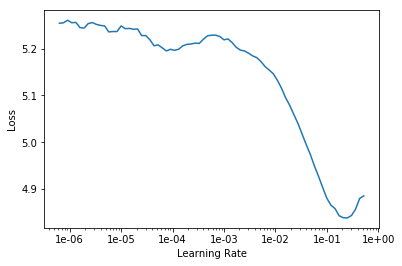

In [10]:
lm_learn.lr_find()
lm_learn.recorder.plot(skip_end=15)

In [11]:
lm_learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.730899,2.540964,0.510082,02:40


In [12]:
lm_learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,2.934283,2.685481,0.501100,02:40


In [ ]:
# optionally save and reload the model (file is about 150MB)
lm_learn.save('fit_head')
lm_learn.load('fit_head');

In [14]:
lm_learn.unfreeze()
lm_learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
lm_learn.save('fine_tuned')
lm_learn.save_encoder('fine_tuned_enc')  
lm_learn.export()


epoch,train_loss,valid_loss,accuracy,time
0,2.323003,2.428123,0.542622,03:10
1,1.992771,2.080651,0.607066,03:10
2,1.869722,1.839746,0.657283,03:10
3,1.360500,1.698494,0.688512,03:10
4,1.272307,1.623179,0.708805,03:10
5,1.013083,1.596957,0.720244,03:10
6,0.905775,1.604948,0.728814,03:10
7,0.721963,1.613399,0.733486,03:09
8,0.639916,1.639424,0.735444,03:09
9,0.641535,1.651715,0.735349,03:09


In [15]:
# optionally save what we have - file is about 300MB
lm_learn.save('fine_tuned')